In [8]:
from qiskit import QuantumCircuit
from qiskit import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

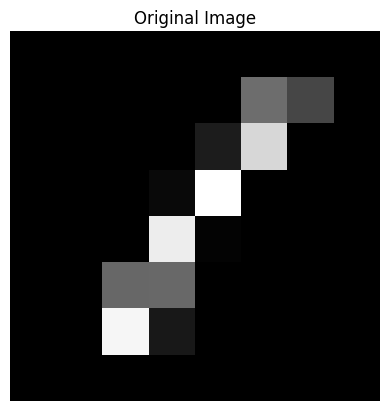

In [14]:
# Read the CSV file. 
# (Assuming the CSV has a label in the first column and pixel values in the remaining 64 columns, for an 8x8 image.)
dataset = pd.read_csv('mnist-resized neqr.csv')

# Select the first image, ignoring the label column.
# Adjust slicing if your file has a different format.
image_data = dataset.to_numpy()[0, 1:]
# Reshape to an 8x8 array and ensure pixel values are integers (0-255)
image = image_data.reshape(8, 8).astype(np.uint8)

plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

In [15]:
# Normalize pixel values to 8-bit integers (0-255)
pixel_values = image.flatten()

# Declare the Quantum and Classical registers
position_qubits = QuantumRegister(6, 'pos')  # 6 qubits for 64 positions
intensity_qubits = QuantumRegister(8, 'int')  # 8 qubits for intensity (8-bit grayscale)
classical_bits = ClassicalRegister(14, 'c')  # For measurement
qc = QuantumCircuit(position_qubits, intensity_qubits, classical_bits)

# Function to apply Hadamard gates to position qubits
def hadamard(circ, n):
    for i in n:
        circ.h(i)

def encode_pixel_values(circ, position_qubits, intensity_qubits, pixel_vals):
    n = len(position_qubits)
    m = len(intensity_qubits)

    for idx, pixel in enumerate(pixel_vals):
        # big-endian index & intensity strings
        bin_idx       = format(idx,   f'0{n}b')  
        intensity_bin = format(pixel, f'0{m}b')

        # 1) “select” the basis state |idx⟩ by flipping pos-qubits where bit=0
        for i, bit in enumerate(bin_idx):
            if bit == '0':
                circ.x(position_qubits[n - 1 - i])

        # 2) for each ‘1’ in the intensity, apply an mcx onto the reversed qubit
        for j, bit in enumerate(intensity_bin):
            if bit == '1':
                circ.mcx(
                    control_qubits=position_qubits,
                    target_qubit=intensity_qubits[m - 1 - j]
                )

        # 3) uncompute the X’s so the pos-register is clean for the next idx
        for i, bit in enumerate(bin_idx):
            if bit == '0':
                circ.x(position_qubits[n - 1 - i])


# NEQR function to encode the image
def neqr(circ, position_qubits, intensity_qubits, pixel_values):
    # Apply Hadamard to position qubits to create superposition
    circ.h(position_qubits)
    # Encode pixel values
    encode_pixel_values(circ, position_qubits, intensity_qubits, pixel_values)


# Apply NEQR encoding
neqr(qc, position_qubits, intensity_qubits, pixel_values)

# Measure all qubits
qc.measure(position_qubits[:] + intensity_qubits[:], classical_bits[:])

# Visualize the circuit
# qc.draw('mpl')

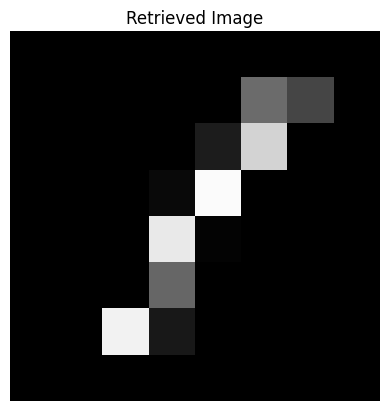

In [16]:
from collections import defaultdict
from qiskit import transpile
from qiskit_aer import AerSimulator
import numpy as np
import matplotlib.pyplot as plt

# 1) Transpile & run
simulator = AerSimulator()
t_qc = transpile(qc, simulator)
result = simulator.run(t_qc, shots=150).result()
counts = result.get_counts()

# 2) Build a dict: position → { intensity → votes }
pos2counts = defaultdict(lambda: defaultdict(int))
for bitstr, cnt in counts.items():
    # MSB-first: first 8 bits = intensity, last 6 bits = position
    intensity = int(bitstr[:8],  2)
    position  = int(bitstr[8:],   2)
    pos2counts[position][intensity] += cnt

# 3) Winner-takes-all decode
flat = np.zeros(64, dtype=int)
for pos, idict in pos2counts.items():
    # pick the intensity with the highest vote-count
    flat[pos] = max(idict.items(), key=lambda kv: kv[1])[0]

# 4) Reshape back to 8×8 and plot
retrieve_image = flat.reshape((8,8)).astype(np.uint8)
plt.imshow(retrieve_image, cmap='gray', vmin=0, vmax=255)
plt.title("Retrieved Image")
plt.axis('off')
plt.show()


In [17]:
from qiskit.quantum_info import Statevector, state_fidelity
import numpy as np

# 1) Flatten & normalize the original image
original_flat = image.flatten().astype(float)
orig_norm     = original_flat / np.linalg.norm(original_flat)

# 2) Flatten & normalize the retrieved image
retrieved_flat = retrieve_image.flatten().astype(float)
retrieved_norm = retrieved_flat / np.linalg.norm(retrieved_flat)

# 3) Build statevectors
original_state  = Statevector(orig_norm)
retrieved_state = Statevector(retrieved_norm)

# 4) Compute fidelity
fidelity = state_fidelity(original_state, retrieved_state)


In [18]:
from analysis import balanced_weighted_mae, ssim, mae

bal_mae = balanced_weighted_mae(image, retrieve_image)
mae_val = mae(image, retrieve_image)
ssim_val = ssim(image, retrieve_image)

print(f"Balanced MAE Fidelity: {bal_mae}")
print(f"MAE Fidelity: {mae_val}")
print(f"SSIM: {ssim_val}")
print(f"Quantum state fidelity: {fidelity}")

Balanced MAE Fidelity: 0.9669934622943401
MAE Fidelity: 0.9938112497329712
SSIM: 0.9743632067732827
Quantum state fidelity: 0.9605590782554907


In [19]:
fidelity_func = balanced_weighted_mae
metric_name = "Weighted MAE"
print("Using weighted MAE for fidelity.")

Using weighted MAE for fidelity.


In [20]:
simulator = AerSimulator()
# Shots: 20, 40, ..., 200, 400, 600, ..., 3000
shot_counts = np.concatenate([
    np.arange(20, 201, 20),
    np.arange(200, 3001, 200)
])
batch_size = 20  # Number of images in the batch
start_index = 0    # Start index for the batch
end_index = start_index + batch_size

def fidelity_for_image_args(args):
    img_idx, shots = args
    image_data = dataset.to_numpy()[img_idx, 1:]
    image = image_data.reshape(8, 8).astype(np.uint8)
    pixel_values = image.flatten()
    position_qubits = QuantumRegister(6, 'pos')
    intensity_qubits = QuantumRegister(8, 'int')
    classical_bits = ClassicalRegister(14, 'c')
    qc = QuantumCircuit(position_qubits, intensity_qubits, classical_bits)
    neqr(qc, position_qubits, intensity_qubits, pixel_values)
    qc.measure(position_qubits[:] + intensity_qubits[:], classical_bits[:])
    t_qc = transpile(qc, simulator)
    result = simulator.run(t_qc, shots=int(shots)).result()
    counts = result.get_counts()
    pos2counts = defaultdict(lambda: defaultdict(int))
    for bitstr, cnt in counts.items():
        intensity = int(bitstr[:8],  2)
        position  = int(bitstr[8:], 2)
        pos2counts[position][intensity] += cnt
    flat = np.zeros(64, dtype=int)
    for pos, idict in pos2counts.items():
        flat[pos] = max(idict.items(), key=lambda kv: kv[1])[0]
    retrieved_image = flat.reshape((8,8)).astype(np.uint8)
    fid = fidelity_func(image, retrieved_image)
    return fid

In [21]:
# Store results for CSV export
all_rows = [('ImageIndex', 'Shots', metric_name)]
fidelities = []  # mean for each shot count
stds = []        # std for each shot count
from concurrent.futures import ThreadPoolExecutor
for shots in shot_counts:
    print(f"Processing {shots} shots for batch of {batch_size} images...")
    args = [(img_idx, shots) for img_idx in range(start_index, end_index)]
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(fidelity_for_image_args, args))
    avg_fid = np.mean(results)
    std_fid = np.std(results)
    fidelities.append(avg_fid)
    stds.append(std_fid)
    for img_idx, fid in zip(range(start_index, end_index), results):
        all_rows.append((img_idx, shots, fid))
    print(f"Shots: {shots}, Avg {metric_name}: {avg_fid:.4f}, Std: {std_fid:.4f}")

Processing 20 shots for batch of 20 images...
Shots: 20, Avg Weighted MAE: 0.6336, Std: 0.0905
Processing 40 shots for batch of 20 images...
Shots: 40, Avg Weighted MAE: 0.7623, Std: 0.0741
Processing 60 shots for batch of 20 images...
Shots: 60, Avg Weighted MAE: 0.8076, Std: 0.0661
Processing 80 shots for batch of 20 images...
Shots: 80, Avg Weighted MAE: 0.8590, Std: 0.0666
Processing 100 shots for batch of 20 images...
Shots: 100, Avg Weighted MAE: 0.8818, Std: 0.0659
Processing 120 shots for batch of 20 images...
Shots: 120, Avg Weighted MAE: 0.9476, Std: 0.0418
Processing 140 shots for batch of 20 images...
Shots: 140, Avg Weighted MAE: 0.9408, Std: 0.0511
Processing 160 shots for batch of 20 images...
Shots: 160, Avg Weighted MAE: 0.9402, Std: 0.0423
Processing 180 shots for batch of 20 images...
Shots: 180, Avg Weighted MAE: 0.9753, Std: 0.0280
Processing 200 shots for batch of 20 images...
Shots: 200, Avg Weighted MAE: 0.9753, Std: 0.0356
Processing 200 shots for batch of 20 i

In [22]:
import pandas as pd
df = pd.DataFrame(all_rows[1:], columns=all_rows[0])
csv_path = "balanced_weighted_mae.csv"
df.to_csv(csv_path, index=False)
print(f"Saved {len(df)} rows to {csv_path}")

Saved 500 rows to balanced_weighted_mae.csv


Standard deviations for each shot count:
Shots: 20, Std: 0.09047047070057672
Shots: 40, Std: 0.07408031325195305
Shots: 60, Std: 0.06612473934026808
Shots: 80, Std: 0.06662912911523901
Shots: 100, Std: 0.06590453315235545
Shots: 120, Std: 0.04184948764880222
Shots: 140, Std: 0.0511443589830797
Shots: 160, Std: 0.0422878973150447
Shots: 180, Std: 0.027989682764024852
Shots: 200, Std: 0.03557764954949051
Shots: 200, Std: 0.028548718190777218
Shots: 400, Std: 0.014194990190299591
Shots: 600, Std: 0.0
Shots: 800, Std: 0.0
Shots: 1000, Std: 0.0
Shots: 1200, Std: 0.0
Shots: 1400, Std: 0.0
Shots: 1600, Std: 0.0
Shots: 1800, Std: 0.0
Shots: 2000, Std: 0.0
Shots: 2200, Std: 0.0
Shots: 2400, Std: 0.0
Shots: 2600, Std: 0.0
Shots: 2800, Std: 0.0
Shots: 3000, Std: 0.0
Shot-fidelity fit failed: Residuals are not finite in the initial point.


/opt/anaconda3/envs/KSASF/lib/python3.13/site-packages/scipy/optimize/_minpack_py.py:982: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma


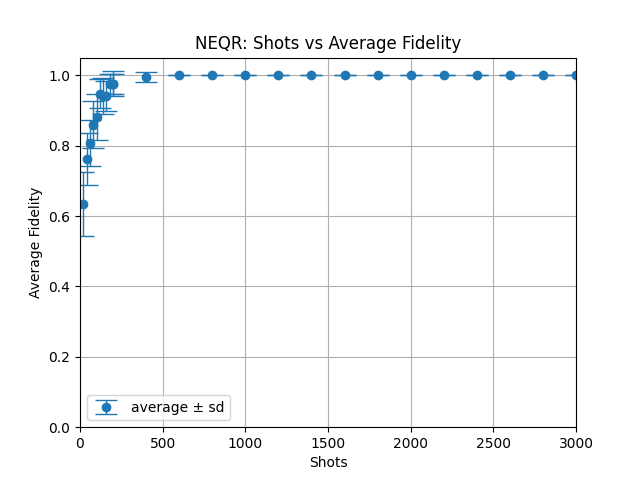

In [ ]:
import numpy as np
avg_metric = np.array(fidelities)   # mean per shot count from cell 10
std_metric = np.array(stds)         # std per shot count from cell 10

# ensure repo root (contains plot.py) is on sys.path and reload module
import sys, pathlib, importlib
sys.path.insert(0, str(pathlib.Path.cwd()))
import plot
importlib.reload(plot)

# create & save plot (plot.plot_metrics writes a PNG in cwd)
plot.plot_metrics(
    shot_counts=shot_counts,
    avg_metric=avg_metric,
    metric_name=metric_name,
    std_metric=std_metric,
    prefix='neqr',
    title='NEQR: Shots vs Average Fidelity'
)

# display saved PNG inline
from IPython.display import Image, display
png = 'neqr_plot_bal_mae.png'
display(Image(filename=png))